# 抽出された特徴量の評価

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [6]:
import glob

onomatpeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

dat = json.load(open("figure_features.json"))
dirname_list = []

for onomatpeia in onomatpeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatpeia
    for dirname in sorted(glob.glob(dirname_pattern)):
        dirname_list.append(dirname)


In [7]:
for shape, d in zip(dat, dirname_list):
    shape = np.array(shape)
    print d, "\t", shape.mean(0)


jsons/clutter/JPN 	[ 0.36993459  0.04494595  0.01214311  0.00802554  0.00372029  0.00284782
  0.00112835  0.00094764  0.00104417  0.46486548  0.05358952  0.01300888
  0.00660356  0.00719529  0.00385711  0.00363533  0.00140909  0.00083989]
jsons/clutter/WRD 	[  3.85585548e-01   4.75371298e-02   1.03544297e-02   4.23022668e-03
   1.69542264e-03   1.92109093e-03   1.13620479e-03   4.18839022e-04
   6.81721004e-04   4.54935361e-01   6.02121161e-02   1.15217413e-02
   7.28805783e-03   4.04810599e-03   3.62032424e-03   2.43909420e-03
   1.46705592e-03   7.63328790e-04]
jsons/gochagocha/JPN 	[ 0.31519134  0.07322604  0.0292087   0.01246879  0.0058406   0.00378865
  0.00156889  0.00107925  0.00057434  0.40928321  0.0914223   0.02941768
  0.01273741  0.00639393  0.00435106  0.00207894  0.00078524  0.0004444 ]
jsons/gochagocha/WRD 	[  3.59979041e-01   3.62479660e-02   9.14820560e-03   4.51232923e-03
   2.25783827e-03   1.41483240e-03   7.17036751e-04   3.06951785e-04
   1.42612286e-04   5.095441

In [8]:
feat = np.array([np.array(d).mean(0) for d in dat])

In [28]:
json_file = 'jsons/clutter/JPN/clutter_JPN_adachi-e.json'
dat = json.load(open(json_file))['angle']
dat = np.array(dat)
hist, _ = np.histogram(dat, bins=18, range=(-np.pi, np.pi))
(hist / float(hist.sum()))

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00588235,  0.04117647,  0.37058824,  0.48235294,
        0.06470588,  0.01764706,  0.        ,  0.00588235,  0.00588235,
        0.        ,  0.00588235,  0.        ])

In [5]:
deg10 = 0.1745

def gen_p_kado():
    return np.pi / 2 + np.random.random() * np.pi / 2

def gen_n_kado():
    return - gen_p_kado()

def gen_p_maru():
    return deg10 + np.random.random() * (np.pi/2 - deg10)

def gen_n_maru():
    return - gen_p_maru()

def gen_massugu():
    return - deg10 + np.random.random() * deg10 * 2

gen_functions = [
    gen_p_kado,
    gen_n_kado,
    gen_p_maru,
    gen_n_maru,
    gen_massugu
    ]


def randomwalk(feat):
    angle = []
    for i in range(100):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_functions[idx]() )
    angle = np.array(angle)
    
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)
    
    return path

def plot_path(path, marker=None):
    size = max(path.max(1) - path.min(1))
    plt.subplot(111).set_aspect(1)

    plt.plot(*path.T, marker=marker)    


In [6]:
for f, d in zip(feat, dirname):
    path = randomwalk(f)
    
    plot_path(path)
    
    plt.savefig("random_walk_images/%s.png" % d.replace('/', '_'))
    plt.clf()


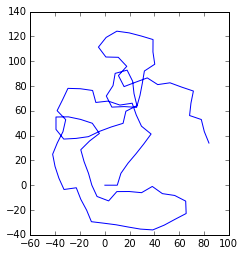

In [7]:
path = randomwalk(feat[2])
plot_path(path)

In [8]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]

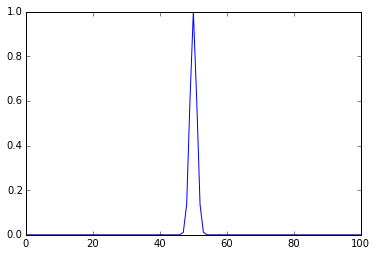

In [9]:
plt.plot( scipy.signal.gaussian(len(path), 1), marker=None )

In [10]:
def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone

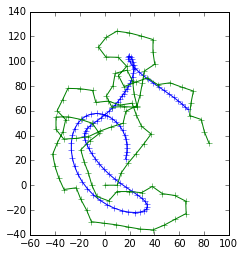

In [11]:
plot_path(gen_bone(path, 5), marker='+')
plot_path(path, marker='+')

In [12]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [13]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [14]:
def to_circle(path, sigma):
    bone = gen_bone(path, 3)
    bone_edge = bone[1:] - bone[:-1]
    
    meat = []

    for i in range(len(path)-1):
        p = path[i] - bone[i]
        e = bone_edge[i]
        arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
        scale = np.linalg.norm(p) / np.linalg.norm(e)
        meat.append([arg, scale])
    
    circle = gen_circle(len(path), 200)
    circle_edge = circle[1:] - circle[:-1]
    
    circle_path = []
    for i in range(len(path)-1):
        arg, scale = meat[i]
        e = circle_edge[i]
        c = circle[i]
        p = c + rotate(e, arg) * scale
        circle_path.append(p)

    circle_path = np.array(circle_path)
    return circle_path

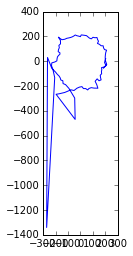

In [16]:
plot_path(to_circle(path, 10))

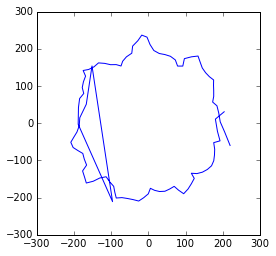

In [62]:
path = randomwalk(feat[5])
plot_path(to_circle(path, 0.1))

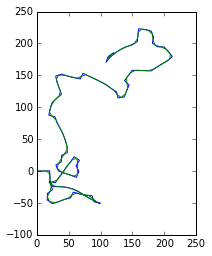

In [61]:
plot_path(path)
plot_path(gen_bone(path, 0.1))